In [1]:
from scipy.stats import norm
import pandas as pd
import pandas_datareader as web
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.optimize import brentq
from scipy.stats import norm

# Configuration variables
ticker = 'ATVI'

# Black-Scholes call and put price
def call_price(sigma, S, K, r, t, d1, d2):
    C = norm.cdf(d1) * S - norm.cdf(d2) * K * np.exp(-r * t)
    return C

def put_price(sigma, S, K, r, t, d1, d2):
    P = -norm.cdf(-d1) * S + norm.cdf(-d2) * K * np.exp(-r * t)
    return P

# Black-Scholes d1 and d2
def d(sigma, S, K, r, t):
    d1 = 1 / (sigma * np.sqrt(t)) * ( np.log(S/K) + (r + sigma**2/2) * t)
    d2 = d1 - sigma * np.sqrt(t)
    return [d1, d2]

# Fetch ticker and options expiration dates
comp = yf.Ticker(ticker)
exp_dates = comp.options

curr_price = comp.history(period='1d')['Close'][0]

# Latest 10 year yield for option price calculation
ten_yr_raw = web.DataReader('DGS10', 'fred', start=datetime(2021, 1, 1))
last_ten_yr = ten_yr_raw.iloc[-1].values[0]


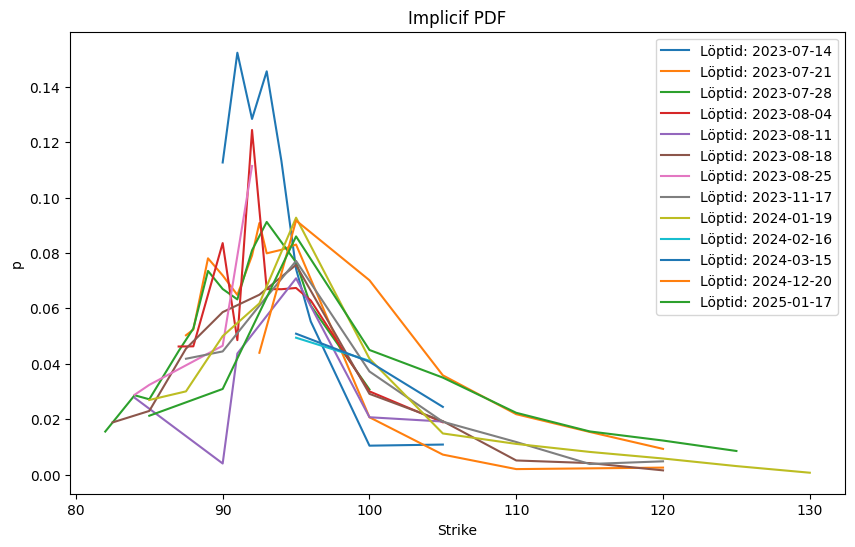

/var/folders/cz/s6vsd4w14lxb2_kkg69ybbbw0000gn/T/ipykernel_9228/2874550161.py:71: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])


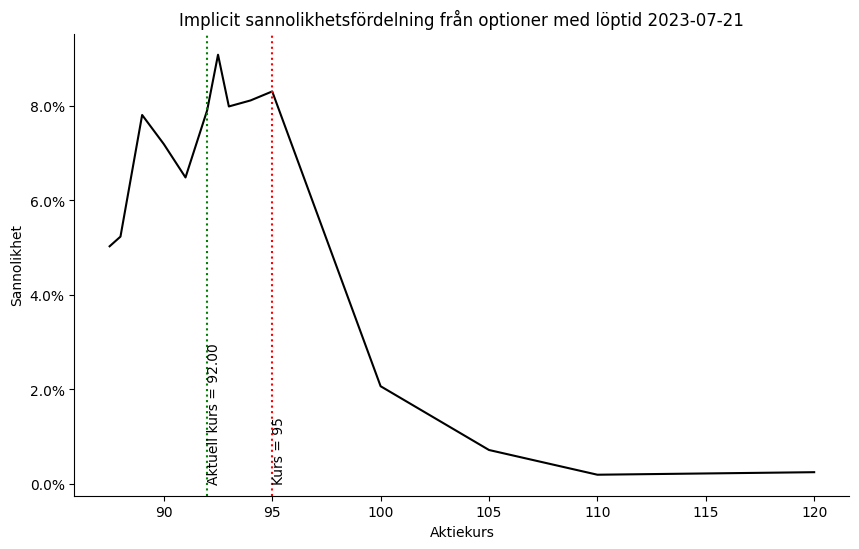

/var/folders/cz/s6vsd4w14lxb2_kkg69ybbbw0000gn/T/ipykernel_9228/2874550161.py:101: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])


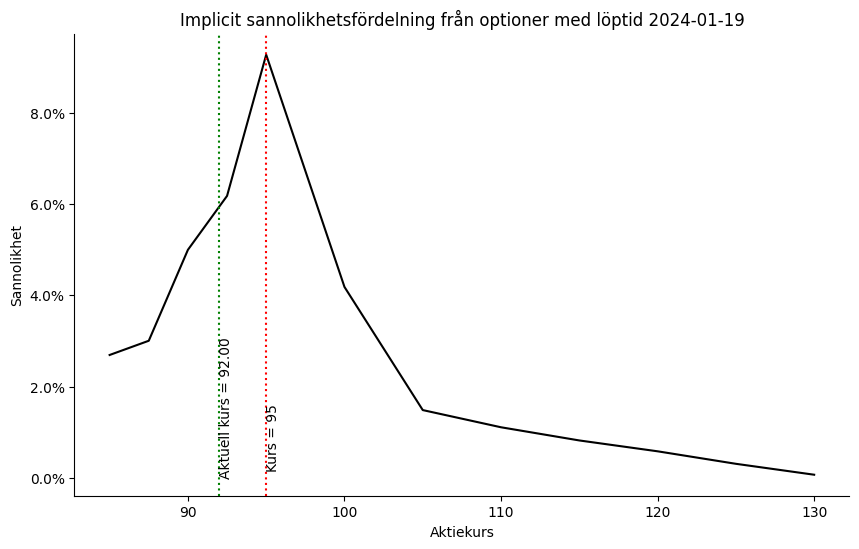

In [2]:


# Brents method objective function
def objective(sigma, *args):
    S, K, r, t, market_price, option_type = args
    d1, d2 = d(sigma, S, K, r, t)
    if option_type == "call":
        model_price = call_price(sigma, S, K, r, t, d1, d2)
    elif option_type == "put":
        model_price = put_price(sigma, S, K, r, t, d1, d2)
    return model_price - market_price

# Black Scholes PDF
def calculate_pdf(K, r, T, sigma, S):
    d2 = (np.log(S / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    pdf = np.exp(r * T) * norm.pdf(d2) / (S * sigma * np.sqrt(T))
    return pdf

pdfs_all = []
strikes_all = []

# Loop through all exp_dates to calculate pdf for each strike
for exp_date in exp_dates:
    options = comp.option_chain(exp_date)
    call_ivs = []
    strikes = []
    for index, row in options.calls.iterrows():
        t = (pd.to_datetime(exp_date) - datetime.now()).days / 365.0
        r = last_ten_yr / 100
        S = curr_price
        K = row['strike']
        market_price = row['lastPrice']
        try:
            implied_vol = brentq(objective, 0.01, 5, args=(S, K, r, t, market_price, "call"))
            call_ivs.append(implied_vol)
            strikes.append(K)  # Add strike
        except ValueError:
            pass  # If we can't solve for implied vol, skip the strike

    # Calculate PDF for each strike
    pdfs = []
    for i in range(len(call_ivs)):
        pdf = calculate_pdf(strikes[i], r, t, call_ivs[i], S)
        pdfs.append(pdf)
    
    # Save pdfs and strikes for each exp_date
    pdfs_all.append(pdfs)
    strikes_all.append(strikes)

# Plot PDF for each exp_date
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}')

plt.title('Implicif PDF')
plt.xlabel('Strike')
plt.ylabel('p')
plt.legend()
plt.show()


In [ ]:

# Plotta pdf för närmaste datumet efter avtalet väntas löpa ut
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2023-07-21':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')
        # Black line
        

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2023-07-21')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')
# y axis in percentage points
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# Make a minimalistic graphic style
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add y-line at strike price 95
plt.axvline(x=95, color='r', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(95, 0.0005, 'Kurs = 95', rotation=90)
# Plot line at curr_price
plt.axvline(x=curr_price, color='g', linestyle='dotted')
# Text at y-line that says the value of curr_price with 2 decimals
plt.text(curr_price, 0.0005, f'Aktuell kurs = {curr_price:.2f}', rotation=90)
# No border for legend
plt.show()


# Plotta pdf för närmaste datumet efter avtalet väntas löpa ut
plt.figure(figsize=(10,6))
for i in range(len(exp_dates)):
    if exp_dates[i] == '2024-01-19':
        plt.plot(strikes_all[i], pdfs_all[i], label=f'Löptid: {exp_dates[i]}', color='black')
        # Black line
        

plt.title('Implicit sannolikhetsfördelning från optioner med löptid 2024-01-19')
plt.xlabel('Aktiekurs')
plt.ylabel('Sannolikhet')
# y axis in percentage points
vals = plt.gca().get_yticks()
plt.gca().set_yticklabels(['{:,.1%}'.format(x) for x in vals])
# Make a minimalistic graphic style
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

# Add y-line at strike price 95
plt.axvline(x=95, color='r', linestyle='dotted')
# Text at y-line that says "strike = 95"
plt.text(95, 0.002, 'Kurs = 95', rotation=90)
# Plot line at curr_price
plt.axvline(x=curr_price, color='g', linestyle='dotted')
# Text at y-line that says the value of curr_price
plt.text(curr_price, 0.0005, f'Aktuell kurs = {curr_price:.2f}', rotation=90)
# No border for legend
plt.show()



Calculate the probabilities of the underlying asset price based on the Black-Scholes model and option chain data from Yahoo Finance.

In [15]:
from scipy.integrate import quad
import numpy
import scipy

# Find the index of the expiry date
expiry_date = '2024-01-19'
index = exp_dates.index(expiry_date)

# Find the corresponding strikes and pdfs
strikes = strikes_all[index]
pdfs = pdfs_all[index]

# Integrate the pdfs over all strikes, should be close to 1
total_sum_of_pdfs = numpy.trapz(pdfs, strikes)

# Integrate the pdfs over strikes greater than 95 with trapz and simps methods
strikes_array = numpy.array(strikes)
pdfs_array = numpy.array(pdfs)
sum_of_pdf_above_strike = numpy.trapz(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95])
print(f'Total sum of PDFs: {total_sum_of_pdfs:.2f}')


print(f'P(X >= 95) = {sum_of_pdf_above_strike/total_sum_of_pdfs:.2f} with \'trapz\' method')
print(f'P(X >= 95) = {scipy.integrate.simps(pdfs_array[strikes_array >= 95], strikes_array[strikes_array >= 95]):.2f} with \'simps\' method')

Total sum of PDFs: 1.16
P(X >= 95) = 0.57 with 'trapz' method
P(X >= 95) = 0.64 with 'simps' method
